Authors: Zhewei Yao <https://github.com/yaozhewei>, Amir Gholami <http://amirgholami.org/>


This tutorial shows how to compute the Hessian information using (randomized) numerical linear algebra for both explicit Hessian (the matrix is given) as well as implicit Hessian (the matrix is ungiven).

We'll start by doing the necessary imports:

In [1]:
import numpy as np
import torch 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from pytorchcv.model_provider import get_model as ptcv_get_model # used to get pretrained model

In [2]:
from utils import * # get the dataset
from pyhessian import hessian # Hessian computation
from density_plot import get_esd_plot # ESD plot


%matplotlib inline

In [3]:
# enable cuda devices
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Example 1: Power Iteration with Numpy

The following part shows how to use power iteration to get the top eigenvalue of a matrix without explicitly having access to it in numpy. We start by creating a random matrix B, compute its ground truth eigenvalues using numpy, and then compare the results with matrix-free power iteration (which does not need direct access to the matrix).

In [4]:
n = 100 # the matrix size

# generate a random matrix
# diag = np.diag(np.random.rand(n)) * 100
# A = np.random.randn(n, n)
# q, _ = np.linalg.qr(A)
# B = q.T @ diag @ q


A = np.random.randn(n, n)
B = A.T @ A

Now let's use numpy to compute the ground truth eigenvalues. We will then check the results with this.

In [5]:
# use np.eigs to get the top eigenvalue of B
eigs, _ = np.linalg.eig(B)
print("The top eigenvalue of B is %.4f" % np.sort(eigs)[-1])

The top eigenvalue of B is 389.7440


Now let's try to comptue the top eigenvalue of B without explicitly accessing B. To do so, we will use a method called Power Iteration:

https://en.wikipedia.org/wiki/Power_iteration

The algorithm is very simple and efficiet to compute the top eigenvalue:
$$v_{i+1} = \frac{Bv_i}{\|Bv_i\|}.$$

As such, we only need to have access to the *application* of B to a given vector $v_i$ and not the matrix B itself. This application is commonly referred to as *matvec* in literature.

In [6]:
# use power iteration to get the top eigenvalue of B
v = np.random.randn(n, 1)
for i in range(40):
    v = v / np.linalg.norm(v)
    eig_power_iteration = v.T @ B @ v
    if (i + 1) % 5 == 0:
        print("Step %2d current estimated top eigvalue: %.4f" % (i+1,eig_power_iteration))
    v = B @ v
print("Finished Power Iteration\n")
print("Ground Truth Top Eigenvalue: %.4f" % np.sort(eigs)[-1])
print("Result with matrix-free Power Iteration: %.4f. The relative error is %.1e" \
      % (eig_power_iteration, abs(eig_power_iteration - np.sort(eigs)[-1]) / np.sort(eigs)[-1] ))

Step  5 current estimated top eigvalue: 313.4102
Step 10 current estimated top eigvalue: 341.4983
Step 15 current estimated top eigvalue: 371.2982
Step 20 current estimated top eigvalue: 385.2666
Step 25 current estimated top eigvalue: 388.7611
Step 30 current estimated top eigvalue: 389.5178
Step 35 current estimated top eigvalue: 389.6864
Step 40 current estimated top eigvalue: 389.7272
Finished Power Iteration

Ground Truth Top Eigenvalue: 389.7440
Result with matrix-free Power Iteration: 389.7272. The relative error is 4.3e-05


As you can see the result of the power iteration and the one we got from numpy match very well.

We can apply the same techinique for neural networks as well, and in particular use it to compute eigenvalues of Hessian!

Importantly there has been a lot of misconception that we can not use Hessian for real world applications since
we need to explicitly form it. Next you will see that this is not correct.

## Example 2: Power Iteration using PyHessian Library
The follwoing part will introduce how to use PyHessian library to compute the top eigenvalue for a least sqaure problem, and compare the result computed by Numpy. 

In [7]:
n = 1000 # number of data points
d = 100 # number of feature dimension

beta = np.random.randn(d, 1) # generate the ground truth solution
A = np.random.randn(n, d) # generate the input data
y = A @ beta # generate the ground truth output 

init_beta = np.random.randn(d, 1)

In [8]:
# use np.eigs to get the top eigenvalue of least square problem \|A init_beta - y\|^2
eigs, _ = np.linalg.eig(2 * A.T @ A)
print("The top eigenvalue of B is %.4f" % np.sort(eigs)[-1])

The top eigenvalue of B is 3415.9960


In [9]:
# transer the problem to pytorch 
A_torch = torch.from_numpy(A).cuda().to(torch.cuda.FloatTensor())
y_torch = torch.from_numpy(y).cuda().to(torch.cuda.FloatTensor())

init_beta_torch = torch.from_numpy(init_beta).cuda().to(torch.cuda.FloatTensor())
init_beta_torch.requires_grad = True

In [10]:
# define the model

class ls_model(torch.nn.Module):
    def __init__(self, param):
        super(ls_model, self).__init__()
        self.beta = nn.Linear(1, d, bias=False)
        self.beta.weight.data = param.t()
    def forward(self, x):
        return self.beta(x)
    
model = ls_model(init_beta_torch)

In [11]:
# define loss function
criterion = torch.nn.MSELoss(reduction='sum')

In [12]:
from pyhessian import hessian # Hessian computation

In [13]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(A_torch, y_torch), cuda=True)

In [16]:
# Now let's compute the top eigenvalue using PyHessian
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
print("The top Hessian eigenvalue of this model is %.4f. Relative error is: %.1e" \
      % (top_eigenvalues[-1], abs(top_eigenvalues[-1]-np.sort(eigs)[-1]) / np.sort(eigs)[-1]) )

The top Hessian eigenvalue of this model is 3381.5845. Relative error is: 1.0e-02


## Example 3: Power Iteration for NN Hessian
Now, let's see how to use PyHessian library to compute the top eigenvalue of NNs.

In [17]:
# get the model 
model = ptcv_get_model("resnet20_cifar10", pretrained=True)
# change the model to eval mode to disable running stats upate
model.eval()

# create loss function
criterion = torch.nn.CrossEntropyLoss()

# get dataset 
train_loader, test_loader = getData()

# for illustrate, we only use one batch to do the tutorial
for inputs, targets in train_loader:
    break

# we use cuda to make the computation fast
model = model.cuda()
inputs, targets = inputs.cuda(), targets.cuda()



Files already downloaded and verified


In [18]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=True)

In [19]:
# Now let's compute the top eigenvalue. This only takes a few seconds.
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[-1])

The top Hessian eigenvalue of this model is 150.3149


In [20]:
# Now let's compute the top 2 eigenavlues and eigenvectors of the Hessian
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
print("The top two eigenvalues of this model are: %.4f %.4f"% (top_eigenvalues[-1],top_eigenvalues[-2]))

The top two eigenvalues of this model are: 93.9245 150.1178


The small difference between this top eigenvalue and the previous one is due to the small number of iterations that we used in Power iteration. You can remove this small difference by increasing the number of iterations for power iteration.

## Example 3.1: Plot Loss Landscape

We can use the Hessian eigenvectors/eigenvalues to analyze the flat/sharpness of the loss landscape of your model, and plot the loss landscape. We will show that this can be more informative than using random directions.

To plot the loss landscape, we first compute the top Hessian eigenvector and then perturb the model parameters along that direction and measure the loss.

In [21]:
# get the top eigenvector
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()

In [22]:
# This is a simple function, that will allow us to perturb the model paramters and get the result
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector')

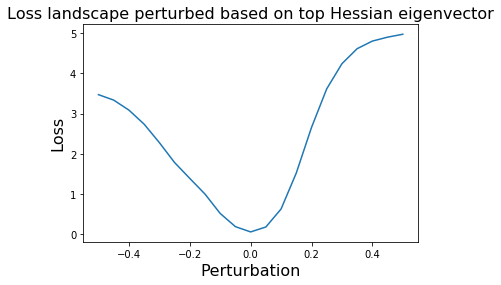

In [23]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Perturbation', fontsize=16)
plt.title('Loss landscape perturbed based on top Hessian eigenvector', fontsize=16)

Now let's compare this with a loss landscape computed based on perturbing the model parameters along a random direction.

Text(0.5, 1.0, 'Loss landscape perturbed based on a random direction')

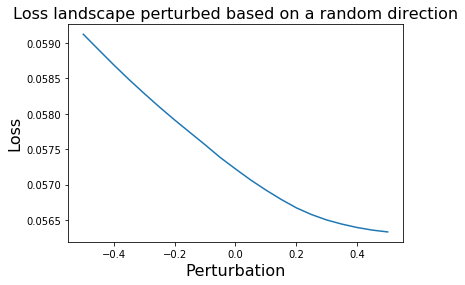

In [24]:
from pyhessian.utils import normalization

# generate random vector to do the loss plot

v = [torch.randn_like(p) for p in model.parameters()]
v = normalization(v)


# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Perturbation', fontsize=16)
plt.title('Loss landscape perturbed based on a random direction', fontsize=16)

Note how different the loss landscape looks. In particular note that there is almost no change in the loss value (see the small scale of the y-axis). This is expected, since for a converged NN, many of the directions are typically degenarate (i.e. they are flat).

## Example 4: Hessian Trace/Diagonal with Numpy

We can also use randomized linear algebra to compute Hessian trace or approximate the Hessian diagonal with very little computational overhead. Let's first start with a numpy example, and then we will show results for a NN.

In [26]:
n = 1000 # the matrix size

# generate the matrix
A = np.random.randn(n, n)
B = A @ A.T

In [27]:
# Direct get the trace 
trace_B_np = np.matrix.trace(B)
print("The trace of B is: %.4f"%trace_B_np)

The trace of B is: 999480.8988


We can approximate the above by using Hutchinson Method. It is very similar to power iteration:

$$Tr(B) = \mathbb{E}[v^TBv],$$
$$Diag(B) = \mathbb{E}[v \bigodot Bv].$$

It can be proved that the above expectation converges with smallest variance to the trace if we use Rademacher random numbers (+/-1). In practice you can also use Gaussian random vectors as well.

In [32]:
# use Hutchinson method to get the trace of B
trace_list = []

for i in range(40):
    v = np.random.randint(2, size=n) 
    v = v.reshape(n, 1) * 2 - 1 # Create Rademacher random numbers
    trace_list.append(v.T @ B @ v)
    trace_B_hutchinson = np.mean(trace_list)
    if (i + 1) % 5 == 0:
        print("Step %.2d, Current estimated trace: %.1f relative error: %.1e"
              %(i+1, trace_B_hutchinson, abs(trace_B_hutchinson - trace_B_np) / trace_B_np))

Step 05, Current estimated trace: 962650.2 relative error: 3.7e-02
Step 10, Current estimated trace: 975413.4 relative error: 2.4e-02
Step 15, Current estimated trace: 987569.3 relative error: 1.2e-02
Step 20, Current estimated trace: 992606.1 relative error: 6.9e-03
Step 25, Current estimated trace: 992113.6 relative error: 7.4e-03
Step 30, Current estimated trace: 994583.7 relative error: 4.9e-03
Step 35, Current estimated trace: 999676.9 relative error: 2.0e-04
Step 40, Current estimated trace: 999377.7 relative error: 1.0e-04


As you can see we can get a very accurate estimate of the trace. Next let's try to approximate the diagonal of B using the matrix-free Hutchinson's method.

In [33]:
# use Hutchinson method to get the diag of B
diag_est = np.zeros([n, 1])
diag_B_np = np.diag(B)
for i in range(20):
    v = np.random.randint(2, size=n)
    v = v.reshape(n, 1) * 2 - 1
    diag_est += np.multiply(v, (B @ v))
    diag_est_err = np.mean(np.abs(diag_est.reshape(-1) / (i+1) - diag_B_np) / diag_B_np)
    if (i + 1) % 5 == 0:
        print("Step %.2d, the current average relative error %.1e:"%(i+1, diag_est_err))

Step 05, the current average relative error 3.7e-01:
Step 10, the current average relative error 2.6e-01:
Step 15, the current average relative error 2.1e-01:
Step 20, the current average relative error 1.8e-01:


## Example 5: Hessian Trace/Diagonal with PyHessian
Now let's repeate the above for computing the trace and diagonal of Hessian for ResNet20.

In [34]:
# get the model 
model = ptcv_get_model("resnet20_cifar10", pretrained=True)
# change the model to eval mode to disable running stats upate
model.eval()

# create loss function
criterion = torch.nn.CrossEntropyLoss()

# get dataset 
train_loader, test_loader = getData()

# for illustrate, we only use one batch to do the tutorial
for inputs, targets in train_loader:
    break

# we use cuda to make the computation fast
model = model.cuda()
inputs, targets = inputs.cuda(), targets.cuda()

Files already downloaded and verified


In [35]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=True)

In [36]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 848.5541


## Example 6: Full spectrum density of Hessian with PyHessian
We can also get the full eigenvalue spectrum density of Hessian using Stochastic Lancoz algorithm.

In [37]:
density_eigen, density_weight = hessian_comp.density()

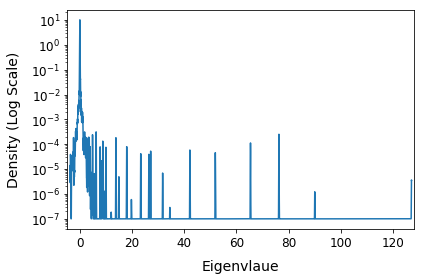

In [38]:
get_esd_plot(density_eigen, density_weight)

The above ESD plot is very interesting and shows that a lot of the eigenvalues of the Hessian are close to zero. This means that a lot of the directions along the loss landscape is almost flat. We expect this based on the loss landscape that we got above when we used a random direction. Another interesting observation is that there are several large Hessian outliers. The other very interesting finding, is that there are a lot of directions with slight negative curvature. This means that we still have not converged to a perfect local minimum that satisfies first and second order optimality conditions.